# Hillshade using elevation model (Optional)

In this tutorial of lesson we will learn how to create a hillshade from a terrain raster in Python. 

In this tutorial we will:

* Understand how to read in and visualize elevation models in Python
* Plot a contour map of the DTM
* Create a hillshade from the DTM

We have learned how to work with raster files in Python in the [Lesson 7 of the course Automating GIS Processes II](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-7/overview.html).

**Data:**

In this tutorial, we’ll travel virtually to [Ylläs](https://en.wikipedia.org/wiki/Yll%C3%A4s) a prominent fell in Finnish Lapland, situated in the northern part of Finland. Ylläs is a mountainous hill characteristic of the region’s rugged landscape. For our analysis, we will use the high-resolution digital elevation model provided by the [National Land Survey of Finland](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/datasets-and-interfaces/product-descriptions/elevation-model-2-m).

<div style="border-left: 4px solid #3498db; background-color: #f0f8ff; padding: 15px; margin: 20px 0;">
    <h3>About Ylläs</h3>
    <p>Ylläs is one of the highest fells in Finland, standing at 718 meters. It is located in the Pallas-Yllästunturi National Park and is a popular destination for outdoor activities such as hiking and skiing. Ylläs is known for its stunning natural landscapes, including vast forests, pristine lakes, and dramatic fells that rise above the surrounding terrain.</p>
    <img src="fig/yllas.jpg" alt="Raster Data Representation" style="max-width:100%; height:auto;">
    <p><em>Image Source: <a href="https://en.wikipedia.org/wiki/Yll%C3%A4s" target="_blank">Wikipedia - Ylläs</a> - <a href="https://www.metsa.fi/en/responsible-business/kiinteistokauppa-eng/business-sites/spectacular-yllas/" target="_blank">Metsähallitus</a></em></p>
</div>

First, let's import the required packages and load our data:

In [1]:
import os
import numpy as np
import requests
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt

dtm_dataset = rio.open('data/U4234A.tif')
dtm_data = dtm_dataset.read(1)

## Visualize the raster and contour lines
Now, let’s create our first visualization of the data and enhance it with contour lines.

Text(0, 0.5, '')

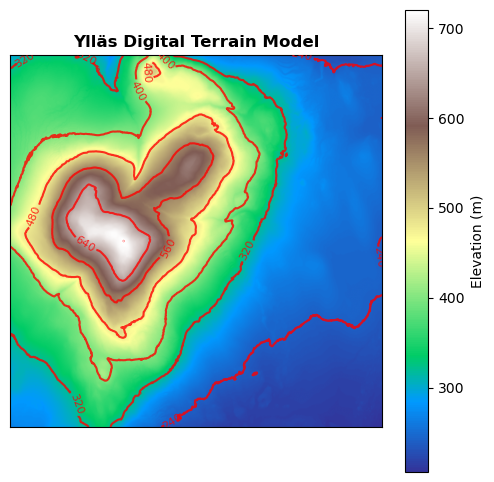

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dtm_map = show(dtm_dataset, title='Ylläs Digital Terrain Model', ax=ax, cmap='terrain')  # specify colormap
show(dtm_dataset, contour=True, ax=ax)  # overlay the contours

im = dtm_map.get_images()[0]
fig.colorbar(im, label='Elevation (m)', ax=ax)  # add a colorbar

# Turn of axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

###  Calculate Hillshade

Hillshade is used to visualize the hypothetical illumination value (from 0-255) of each pixel on a surface given a specified light source. To calculate hillshade, we need the zenith (altitude) and azimuth of the illumination source, as well as the slope and aspect of the terrain. The formula for hillshade is:

$$Hillshade = 255.0 * (( cos(zenith_I)*cos(slope_T))+(sin(zenith_I)*sin(slope_T)*cos(azimuth_I-aspect_T))$$

Where all angles are in radians. 

You can read more about how hillshades work, [here](https://pro.arcgis.com/en/pro-app/3.0/tool-reference/3d-analyst/how-hillshade-works.htm#).  

In [3]:
# Function to compute hillshade from elevation data
def hillshade(elevation_data, azimuth_angle, sun_elevation):
    # Adjust the azimuth to fit the mathematical standard (clockwise from north)
    azimuth_angle = 360.0 - azimuth_angle
    
    # Calculate the gradient in both x and y directions
    gradient_x, gradient_y = np.gradient(elevation_data)
    
    # Calculate the slope and aspect of the terrain
    slope_angle = np.pi / 2.0 - np.arctan(np.sqrt(gradient_x**2 + gradient_y**2))
    aspect_angle = np.arctan2(-gradient_x, gradient_y)
    
    # Convert azimuth and sun altitude to radians
    azimuth_in_radians = azimuth_angle * np.pi / 180.0
    sun_elevation_in_radians = sun_elevation * np.pi / 180.0
    
    # Compute the hillshade using the formula
    hillshade_values = (np.sin(sun_elevation_in_radians) * np.sin(slope_angle) +
                        np.cos(sun_elevation_in_radians) * np.cos(slope_angle) *
                        np.cos(azimuth_in_radians - np.pi / 2.0 - aspect_angle))
    
    # Normalize the hillshade values to a 0-255 range
    hillshade_norm = 255 * (hillshade_values + 1) / 2
    
    return hillshade_norm

Now that we have a function to generate hillshade, we need to read in the DTM raster using rasterio and then calculate hillshade using the `hillshade` function. We can then plot both.

Text(0, 0.5, '')

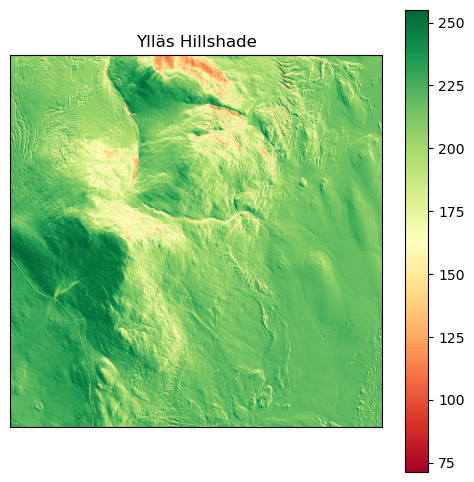

In [20]:
# Use hillshade function on the DTM data array
hs_data = hillshade(dtm_data,225,45)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ext = [dtm_dataset.bounds.left, dtm_dataset.bounds.right, dtm_dataset.bounds.bottom, dtm_dataset.bounds.top]
plt.imshow(hs_data,extent=ext)
plt.colorbar(); plt.set_cmap('RdYlGn'); 
plt.title('Ylläs Hillshade')

# Turn of axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

Text(0, 0.5, '')

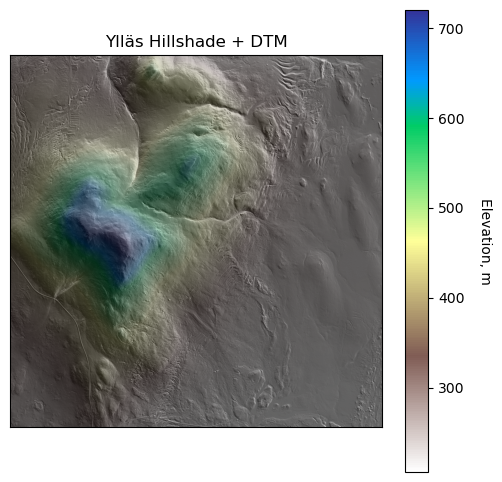

In [24]:
# Overlay transparent hillshade on DTM:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
im1 = plt.imshow(dtm_data,cmap='terrain_r',extent=ext); 
cbar = plt.colorbar(); cbar.set_label('Elevation, m',rotation=270,labelpad=20)
im2 = plt.imshow(hs_data,cmap='Greys',alpha=0.8,extent=ext); #plt.colorbar()
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.grid('off'); 
#plt.colorbar();  
plt.title('Ylläs Hillshade + DTM');

# Turn of axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')